<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/ML-2025a/blob/main/PINN_Plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
# Install dependencies for Colab
!pip install pytorch-lightning clearml

import math
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from clearml import Task
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from dataclasses import dataclass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 8.6 MB/s eta 0:00:00


In [2]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


# 🧠 Theoretical Introduction: Dimensionless PINNs for Parallel Plate Flow

We consider the steady, fully developed flow of an incompressible Newtonian fluid between two infinite parallel plates separated by distance \(h\).  
The velocity is unidirectional along \(x\), varying only in the transverse direction \(y\), so the governing equation reduces to:

$$
\mu \frac{d^2 u}{dy^2} = \frac{dp}{dx}
$$

where $\mu$ is dynamic viscosity, $\frac{dp}{dx}$ — constant pressure gradient (typically negative).

The **no-slip boundary conditions** are applied at both plates:
<!--  -->
$$
u\left(-\tfrac{h}{2}\right) = 0, \quad u\left(\tfrac{h}{2}\right) = 0
$$

---

## ✅ Nondimensionalization

We define dimensionless variables:

$$
Y = \frac{y}{h}, \qquad U = \frac{u}{U_\mathrm{ref}}, \qquad
\Pi = \frac{h^2}{\mu U_\mathrm{ref}} \left(\frac{dp}{dx}\right)
$$

Substituting into the PDE gives the **dimensionless Poisson equation**:

$$
\frac{d^2 U}{dY^2} = \Pi
$$

with **boundary conditions**:

$$
U(-\tfrac{1}{2}) = 0, \quad U(\tfrac{1}{2}) = 0
$$

The **analytic solution** in nondimensional form is:

$$
U(Y) = \frac{\Pi}{2} \left( \tfrac{1}{4} - Y^2 \right)
$$

---

## ⚙️ Physics-Informed Neural Network (PINN) Formulation

We approximate $U(Y)$ using a neural network $\hat{U}(Y)$ and enforce physics via loss minimization.

The total loss combines:

- **PDE residual loss** — enforcing the governing equation  
- **Boundary loss** — enforcing no-slip at $Y = \pm \tfrac{1}{2}$

$$
\mathcal{L} =
\underbrace{
\frac{1}{N_r} \sum_{i=1}^{N_r}
\left|
\frac{d^2 \hat{U}}{dY^2}(Y_i) - \Pi
\right|^2
}_{\text{Physics loss}}
+
\underbrace{
\frac{1}{N_b} \sum_{j=1}^{N_b}
\left|
\hat{U}(Y_j) - U_j
\right|^2
}_{\text{Boundary loss}}
$$

# Model

In [3]:
torch.set_default_dtype(torch.float32)
pl.seed_everything(42)

# ----------------------------
# Config
# ----------------------------
@dataclass
class Config:
    # physics (used for physical back-transforms; training is dimensionless)
    h: float = 0.001               # we work in Y in [-0.5, 0.5];
    mu: float = 0.000001               # we work in Y in [-0.5, 0.5];
    dpdx: float = 100000.0
    # training hyperparams
    lr: float = 1e-3
    epochs: int = 1000
    n_colloc_per_pi: int = 128
    n_pi_train: int = 60         # number of distinct Π values in training
    n_pi_val: int = 40           # number of distinct Π values in validation (held out)
    pi_min: float = 5.0          # Π range (training)
    pi_max: float = 5.0
    # checkpointing
    task_name: str = "PINN_plates_dimless_generalized"
    ckpt_dir: str = "checkpoints"
    ckpt_name: str = "pinn_dimless-{epoch:03d}-{val_loss:.6f}"
    # network
    layers: tuple = (2, 64, 64, 64, 1)  # input 2 => [Y, Π]

cfg = Config()

task = Task.init(
    project_name="PINN_Project",   # choose a descriptive project name
    task_name=cfg.task_name,  # descriptive task name
)

# task.connect(params)
tb_logger = TensorBoardLogger(
    save_dir="logs",  # ClearML will automatically monitor this
    name=cfg.task_name,
    # version=f"bs_{HP['batch_size']}_lr_{HP['lr_simclr']}"
  )

# ----------------------------
# Utilities
# ----------------------------
def sample_uniform(n, a, b, device):
    return (a + (b - a) * torch.rand(n, 1, device=device))

def make_grid_y(n, device):
    return torch.linspace(-0.5, 0.5, n, device=device).reshape(-1, 1)

def generate_family_batch(pi_values, n_colloc_per_pi, device):
    """
    Build collocation and BC batches for a list of Π values.
    For each Π, we create:
      - collocation points (Y, Π)
      - boundary points at Y = {-0.5, 0.5} with target U=0
    Returns a dict of tensors concatenated across all Π.
    """
    Ys = []
    Pis = []
    Yb = []
    Pib = []
    Ub = []

    for pi in pi_values:
        # Collocation: Y in [-0.5, 0.5]
        Yc = make_grid_y(n_colloc_per_pi, device)
        Pc = torch.full_like(Yc, fill_value=pi.item())
        Ys.append(Yc)
        Pis.append(pc := Pc)  # noqa: F841

        # Boundary (two points per Π)
        Y_bc = torch.tensor([[-0.5], [0.5]], device=device, dtype=torch.float32)
        P_bc = torch.full_like(Y_bc, fill_value=pi.item())
        U_bc = torch.zeros_like(Y_bc)
        Yb.append(Y_bc)
        Pib.append(P_bc)
        Ub.append(U_bc)

    Y_colloc = torch.cat(Ys, dim=0)
    Pi_colloc = torch.cat(Pis, dim=0)
    Y_bc = torch.cat(Yb, dim=0)
    Pi_bc = torch.cat(Pib, dim=0)
    U_bc = torch.cat(Ub, dim=0)

    X_colloc = torch.cat([Y_colloc, Pi_colloc], dim=1)  # [N, 2]
    X_bc = torch.cat([Y_bc, Pi_bc], dim=1)              # [2*len(pi_values), 2]

    return {
        "X_colloc": X_colloc,
        "Y_colloc": Y_colloc,   # keep Y separately for derivatives
        "X_bc": X_bc,
        "U_bc": U_bc
    }

def split_pi_train_val(pi_min, pi_max, n_train, n_val, device):
    # Sample a superset and split into disjoint train/val sets
    pis_all = torch.linspace(pi_min, pi_max, steps=n_train + n_val + 4, device=device)
    # pick train indices and val indices disjointly (e.g., every other)
    train_idx = torch.arange(0, n_train, device=device)
    val_idx = torch.arange(n_train, n_train + n_val, device=device)
    pi_train = pis_all[train_idx]
    pi_val = pis_all[val_idx]
    return pi_train.reshape(-1, 1), pi_val.reshape(-1, 1)

# ----------------------------
# Dataset / DataModule
# ----------------------------
class FamilyDataset(torch.utils.data.Dataset):
    """Single-item dataset that returns a prebuilt batch (for Lightning convenience)."""
    def __init__(self, batch_dict):
        super().__init__()
        self.batch_dict = batch_dict

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.batch_dict

class PINNDataModule(pl.LightningDataModule):
    def __init__(self, cfg: Config, device="cpu"):
        super().__init__()
        self.cfg = cfg
        self.device_ = device

    def setup(self, stage=None):
        device = self.device_
        # Disjoint Π sets: train vs val (held-out Π)
        pi_train, pi_val = split_pi_train_val(cfg.pi_min, cfg.pi_max, cfg.n_pi_train, cfg.n_pi_val, device)
        self.train_batch = generate_family_batch(pi_train, cfg.n_colloc_per_pi, device)
        self.val_batch = generate_family_batch(pi_val,   cfg.n_colloc_per_pi, device)

    def train_dataloader(self):
        return DataLoader(FamilyDataset(self.train_batch), batch_size=1, shuffle=False)

    def val_dataloader(self):
        return DataLoader(FamilyDataset(self.val_batch), batch_size=1, shuffle=False)

# ----------------------------
# PINN model (dimensionless)
# ----------------------------
class PINN(pl.LightningModule):
    """
    Network takes X = [Y, Π] and predicts U_hat(Y, Π).
    PDE residual uses d^2 U / dY^2 = Π (dimensionless).
    """
    def __init__(self, layers, lr):
        super().__init__()
        self.save_hyperparameters(ignore=["layers"])  # store lr
        self.lr = lr
        self.net = self._build_mlp(layers)
        self.act = nn.Tanh()

    def _build_mlp(self, sizes):
        layers = []
        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
        return nn.ModuleList(layers)

    def forward(self, X):
        # X = [Y, Π]
        out = X
        for layer in self.net[:-1]:
            out = self.act(layer(out))
        out = self.net[-1](out)
        return out  # U_hat

    def _second_deriv_wrt_Y(self, X, Y_only):
        """
        Compute d^2U/dY^2 by autograd.
        - X requires grad for Y dimension; Π is treated as constant (no derivative).
        """
        X = X.clone().detach().requires_grad_(True)
        U = self.forward(X)

        # gradient wrt inputs [dU/dY, dU/dΠ]
        grads = torch.autograd.grad(U, X, grad_outputs=torch.ones_like(U), create_graph=True, retain_graph=True)[0]
        dU_dY = grads[:, :1]  # first column corresponds to Y

        grads2 = torch.autograd.grad(dU_dY, X, grad_outputs=torch.ones_like(dU_dY), create_graph=True, retain_graph=True)[0]
        d2U_dY2 = grads2[:, :1]
        return d2U_dY2

    def _pde_residual(self, batch):
        Xc = batch["X_colloc"]  # [N, 2] = [Y, Π]
        Y  = batch["Y_colloc"]  # [N, 1]
        Pi = Xc[:, 1:2]
        U_YY = self._second_deriv_wrt_Y(Xc, Y)
        res = U_YY - Pi
        return res

    def training_step(self, batch, batch_idx):
        # PDE residual loss
        res = self._pde_residual(batch)
        pde_loss = torch.mean(res**2)

        # Boundary loss
        Xb = batch["X_bc"]
        Ub_tgt = batch["U_bc"]
        Ub_pred = self.forward(Xb)
        bc_loss = nn.functional.mse_loss(Ub_pred, Ub_tgt)

        loss = pde_loss + bc_loss
        self.log_dict({"train_pde": pde_loss, "train_bc": bc_loss, "train_loss": loss}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Ensure autograd is enabled during validation (Lightning disables it by default)
        with torch.enable_grad():
            res = self._pde_residual(batch)
            pde_loss = torch.mean(res**2)
            Xb = batch["X_bc"]
            Ub_tgt = batch["U_bc"]
            Ub_pred = self.forward(Xb)
            bc_loss = nn.functional.mse_loss(Ub_pred, Ub_tgt)
            val_loss = pde_loss + bc_loss

        self.log_dict({"val_pde": pde_loss, "val_bc": bc_loss, "val_loss": val_loss}, prog_bar=True)
        return val_loss


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# ----------------------------
# Train
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
dm = PINNDataModule(cfg, device=device)
dm.setup()

model = PINN(layers=cfg.layers, lr=cfg.lr)

ckpt_cb = ModelCheckpoint(
    dirpath=cfg.ckpt_dir,
    filename=cfg.ckpt_name,
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    # save_last=True
)

trainer = pl.Trainer(
    max_epochs=cfg.epochs,
    accelerator="auto",
    callbacks=[ckpt_cb],
    log_every_n_steps=100,
    check_val_every_n_epoch=100
)

trainer.fit(model, datamodule=dm)

print("Best checkpoint:", ckpt_cb.best_model_path)


INFO:lightning_fabric.utilities.seed:Seed set to 42


ClearML Task: created new task id=26d3877a2a1f4914ab939bdda0fab528


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


2025-09-30 14:46:08,901 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/3b8e0332a8dc4f6ba4a5abbb428a0880/experiments/26d3877a2a1f4914ab939bdda0fab528/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | ModuleList | 8.6 K  | train
1 | act  | Tanh       | 0      | train
--------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:310: PossibleUserWarning:

The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-09-30 14:48:10,064 - clearml.frameworks - INFO - Found existing registered model id=3e68952eb8b24aa19f2e3cc43d926972 [/content/checkpoints/pinn_dimless-epoch=599-val_loss=0.000000.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-09-30 14:48:50,609 - clearml.frameworks - INFO - Found existing registered model id=d4480f4ac4114d7884289ecf2a170da1 [/content/checkpoints/pinn_dimless-epoch=799-val_loss=0.000000.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


Best checkpoint: /content/checkpoints/pinn_dimless-epoch=799-val_loss=0.000000.ckpt


In [4]:
# %% Helper: physical prediction for given (h, mu, dpdx)
@torch.no_grad()
def predict_physical_profile(model, h, mu, dpdx, n_points=200, device="cpu"):
    """
    Returns y [m], u [m/s] predicted by the trained dimensionless PINN, for a given physical case.
    """
    # reference velocity & Pi
    U_ref = (h**2) / (2.0 * mu) * abs(dpdx)
    Pi = (h**2) / (mu * U_ref) * (-dpdx)  # positive for dpdx<0

    # build inputs
    Y = torch.linspace(-0.5, 0.5, n_points, device=device).reshape(-1, 1)
    Pi_col = torch.full_like(Y, fill_value=float(Pi))
    X = torch.cat([Y, Pi_col], dim=1)

    model = model.to(device)
    U_hat = model(X).squeeze(1).cpu().numpy()
    y = (Y.squeeze(1).cpu().numpy()) * h
    u = U_hat * U_ref
    return y, u, U_ref, Pi

# Example: use the same h, mu, dpdx you used originally (units: m, Pa*s, Pa/m)
h = 0.001
mu = 0.001
dpdx = -1.0e4

best_model = PINN.load_from_checkpoint(ckpt_cb.best_model_path, layers=cfg.layers, lr=cfg.lr)
y_phys, u_phys, U_ref, Pi_used = predict_physical_profile(best_model, h=h, mu=mu, dpdx=dpdx, device=device)

print(f"Used U_ref={U_ref:.6e}, Pi={Pi_used:.4f}, y range [{y_phys.min():.3e}, {y_phys.max():.3e}] m")
print("Sample u(m/s):", u_phys[:5])


Used U_ref=5.000000e+00, Pi=2.0000, y range [-5.000e-04, 5.000e-04] m
Sample u(m/s): [48.28469  48.26367  48.242386 48.220833 48.199005]


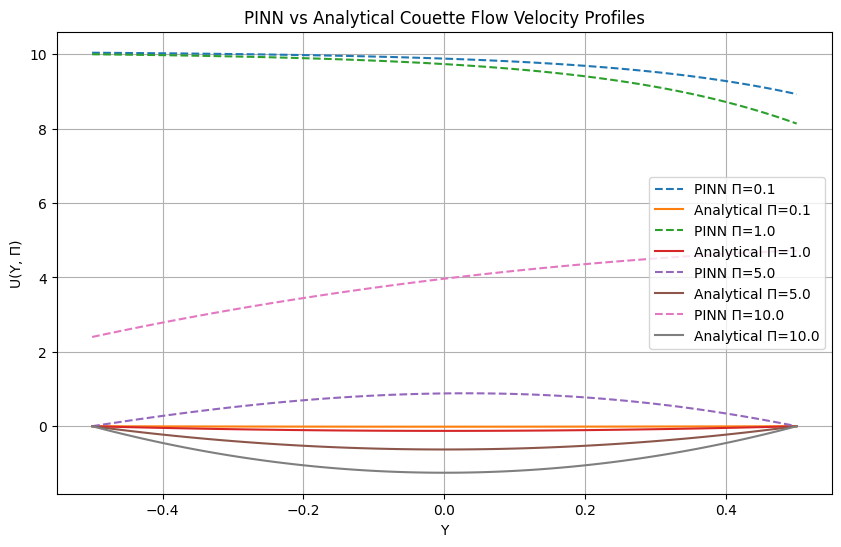

In [5]:
# Evaluation grid
n_points = 100
Y_grid = torch.linspace(-0.5, 0.5, n_points, device=device).reshape(-1,1)

Pi_values = [0.1, 1.0, 5.0, 10.0]

results_table = []

plt.figure(figsize=(10,6))
for pi in Pi_values:
    Pi_grid = torch.full_like(Y_grid, fill_value=pi)
    X_grid = torch.cat([Y_grid, Pi_grid], dim=1)

    # PINN prediction
    with torch.no_grad():
        U_pred = best_model(X_grid).cpu().numpy().flatten()

    # Analytical solution
    U_analytical = (pi/2)*(Y_grid.cpu().numpy().flatten()**2 - 0.25)

    # Calculate errors at key points
    idx_center = n_points//2        # Y=0
    idx_top = 0                     # Y=-0.5
    idx_bottom = n_points-1         # Y=0.5

    error_center = abs(U_pred[idx_center] - U_analytical[idx_center])
    error_top    = abs(U_pred[idx_top] - U_analytical[idx_top])
    error_bottom = abs(U_pred[idx_bottom] - U_analytical[idx_bottom])

    results_table.append({
        "Pi": pi,
        "U_pr(Y=0)": U_pred[idx_center],
        "U_an(Y=0)": U_analytical[idx_center],
        "Error(Y=0)": error_center,
        "U_pr(Y=-0.5)": U_pred[idx_top],
        "U_an(Y=-0.5)": U_analytical[idx_top],
        "Error(Y=-0.5)": error_top,
        "U_pr(Y=0.5)": U_pred[idx_bottom],
        "U_an(Y=0.5)": U_analytical[idx_bottom],
        "Error(Y=0.5)": error_bottom
    })

    # Plot velocity profiles
    plt.plot(Y_grid.cpu(), U_pred, '--', label=f"PINN Π={pi}")
    plt.plot(Y_grid.cpu(), U_analytical, '-', label=f"Analytical Π={pi}")

plt.xlabel("Y")
plt.ylabel("U(Y, Π)")
plt.title("PINN vs Analytical Couette Flow Velocity Profiles")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pandas as pd
df_results = pd.DataFrame(results_table)
pd.set_option("display.float_format", "{:.6f}".format)
print(df_results)


         Pi  U_pr(Y=0)  U_an(Y=0)  Error(Y=0)  U_pr(Y=-0.5)  U_an(Y=-0.5)  \
0  0.100000   9.878529  -0.012499    9.891027     10.040522      0.000000   
1  1.000000   9.729021  -0.124987    9.854009      9.999489      0.000000   
2  5.000000   0.882913  -0.624936    1.507849      0.000088      0.000000   
3 10.000000   3.977170  -1.249872    5.227043      2.399320      0.000000   

   Error(Y=-0.5)  U_pr(Y=0.5)  U_an(Y=0.5)  Error(Y=0.5)  
0      10.040522     8.927496     0.000000      8.927496  
1       9.999489     8.135346     0.000000      8.135346  
2       0.000088     0.000081     0.000000      0.000081  
3       2.399320     4.723893     0.000000      4.723893  


In [10]:
# --- Inspect one batch from train and val ---

dm = PINNDataModule(cfg, device=device)
dm.setup()

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

print("\n=== TRAIN BATCH ===")
for k, v in train_batch.items():
    print(f"{k}: shape={v.shape}")
    print(v[0,:5])  # print first 10 rows for brevity

print("\n=== VAL BATCH ===")
for k, v in val_batch.items():
    print(f"{k}: shape={v.shape}")
    print(v[0,:5])



=== TRAIN BATCH ===
X_colloc: shape=torch.Size([1, 7680, 2])
tensor([[-0.5000,  5.0000],
        [-0.4921,  5.0000],
        [-0.4843,  5.0000],
        [-0.4764,  5.0000],
        [-0.4685,  5.0000]])
Y_colloc: shape=torch.Size([1, 7680, 1])
tensor([[-0.5000],
        [-0.4921],
        [-0.4843],
        [-0.4764],
        [-0.4685]])
X_bc: shape=torch.Size([1, 120, 2])
tensor([[-0.5000,  5.0000],
        [ 0.5000,  5.0000],
        [-0.5000,  5.0000],
        [ 0.5000,  5.0000],
        [-0.5000,  5.0000]])
U_bc: shape=torch.Size([1, 120, 1])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

=== VAL BATCH ===
X_colloc: shape=torch.Size([1, 5120, 2])
tensor([[-0.5000,  5.0000],
        [-0.4921,  5.0000],
        [-0.4843,  5.0000],
        [-0.4764,  5.0000],
        [-0.4685,  5.0000]])
Y_colloc: shape=torch.Size([1, 5120, 1])
tensor([[-0.5000],
        [-0.4921],
        [-0.4843],
        [-0.4764],
        [-0.4685]])
X_bc: shape=torch.Size([1, 80, 2])
ten

In [7]:
task.close()